In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import integrate
import pickle
import h5py
from astropy import constants as c
from astropy import units as u

sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as phys

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../../matplotlibrc')

In [2]:
DATA_DIR = '../data/cooling_rates'

In [3]:
from rates import *
from utils import *

## 1. photon cross sections & rates

$$\Gamma_\text{int}=\frac{dN}{dt}=nc\int\frac{d\sigma}{dE'}\Big|_{E'}dE'$$
$$\Gamma_\text{cool}\equiv t_\text{cool}^{-1}=\left|\frac{d\log E}{dt}\right|=\frac{1}{E}\left|\frac{dE}{dt}\right|=\frac{nc}{E}\int|\Delta E'|\frac{d\sigma}{dE'}\Big|_{E'}dE'$$

### pair production on fully ionized matter
1989ApJ...344..551Z (Zdziarski and Svensson 1989, Eq.5.9-10)
$$\frac{d\tau}{dl}=\frac{d\tau}{c_0dt}=\frac{1}{c_0}\Gamma=n_\text{target}\sigma$$
$$\frac{d\tau}{d\tilde{l}}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2\frac{c_0}{H_0}\left(\log2\epsilon-\frac{109}{42}\right)$$
where, $d\tilde l = \frac{H_0}{c_0}dl$, $\epsilon = E/m_e$, $\alpha_f=1/137$, $r_0$ is electron classical radius.
$$\Gamma=c_0\frac{d\tau}{dl}=c_0\frac{H_0}{c_0}\frac{d\tau}{d\tilde l}=\frac{20}{3}n_e^0(1+z)^3\alpha_f r_0^2c_0\left(\log2\epsilon-\frac{109}{42}\right)$$

### 1.1 plot rates

In [4]:
# define grid
Ep_log10lim = (2, 13)
rs_log10lim = (0, 3.5)
Ep_s = np.logspace(*Ep_log10lim, 100)
rs_s = np.logspace(*rs_log10lim, 100)
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Ep_s)))
a_ss      = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

In [5]:
# calculate rates
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, phph_scat_cool_rate,
         compton_rate, compton_cool_rate, photoion_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = {}
    for func in funcs:
        name = func.__name__
        print(key, name, flush=True)
        rate_ss = []
        for rs in tqdm(rs_s):
            rate_s = []
            xHeII = xHII * phys.nHe/phys.nH
            for Ep in Ep_s:
                rate_s.append(func(Ep, rs, xHII=xHII, xHeII=xHeII))
            rate_ss.append(rate_s)
        rate_ss_dict[key][name] = rate_ss.copy()

xHII=1e-4 pp_CMB_rate


100%|██████████| 100/100 [00:11<00:00,  8.88it/s]

xHII=1e-4 pp_matter_rate



100%|██████████| 100/100 [00:00<00:00, 484.93it/s]

xHII=1e-4 phph_scat_rate



100%|██████████| 100/100 [00:00<00:00, 9460.91it/s]

xHII=1e-4 phph_scat_cool_rate



100%|██████████| 100/100 [00:00<00:00, 612.18it/s]

xHII=1e-4 compton_rate



100%|██████████| 100/100 [00:02<00:00, 46.97it/s]

xHII=1e-4 compton_cool_rate



100%|██████████| 100/100 [00:02<00:00, 40.31it/s]

xHII=1e-4 photoion_rate



100%|██████████| 100/100 [00:00<00:00, 638.45it/s]

xHII=1-1e-4 pp_CMB_rate



100%|██████████| 100/100 [00:11<00:00,  8.89it/s]

xHII=1-1e-4 pp_matter_rate



100%|██████████| 100/100 [00:00<00:00, 487.33it/s]

xHII=1-1e-4 phph_scat_rate



100%|██████████| 100/100 [00:00<00:00, 9473.73it/s]

xHII=1-1e-4 phph_scat_cool_rate



100%|██████████| 100/100 [00:00<00:00, 606.34it/s]

xHII=1-1e-4 compton_rate



100%|██████████| 100/100 [00:02<00:00, 47.05it/s]

xHII=1-1e-4 compton_cool_rate



100%|██████████| 100/100 [00:02<00:00, 40.38it/s]

xHII=1-1e-4 photoion_rate



100%|██████████| 100/100 [00:00<00:00, 645.26it/s]


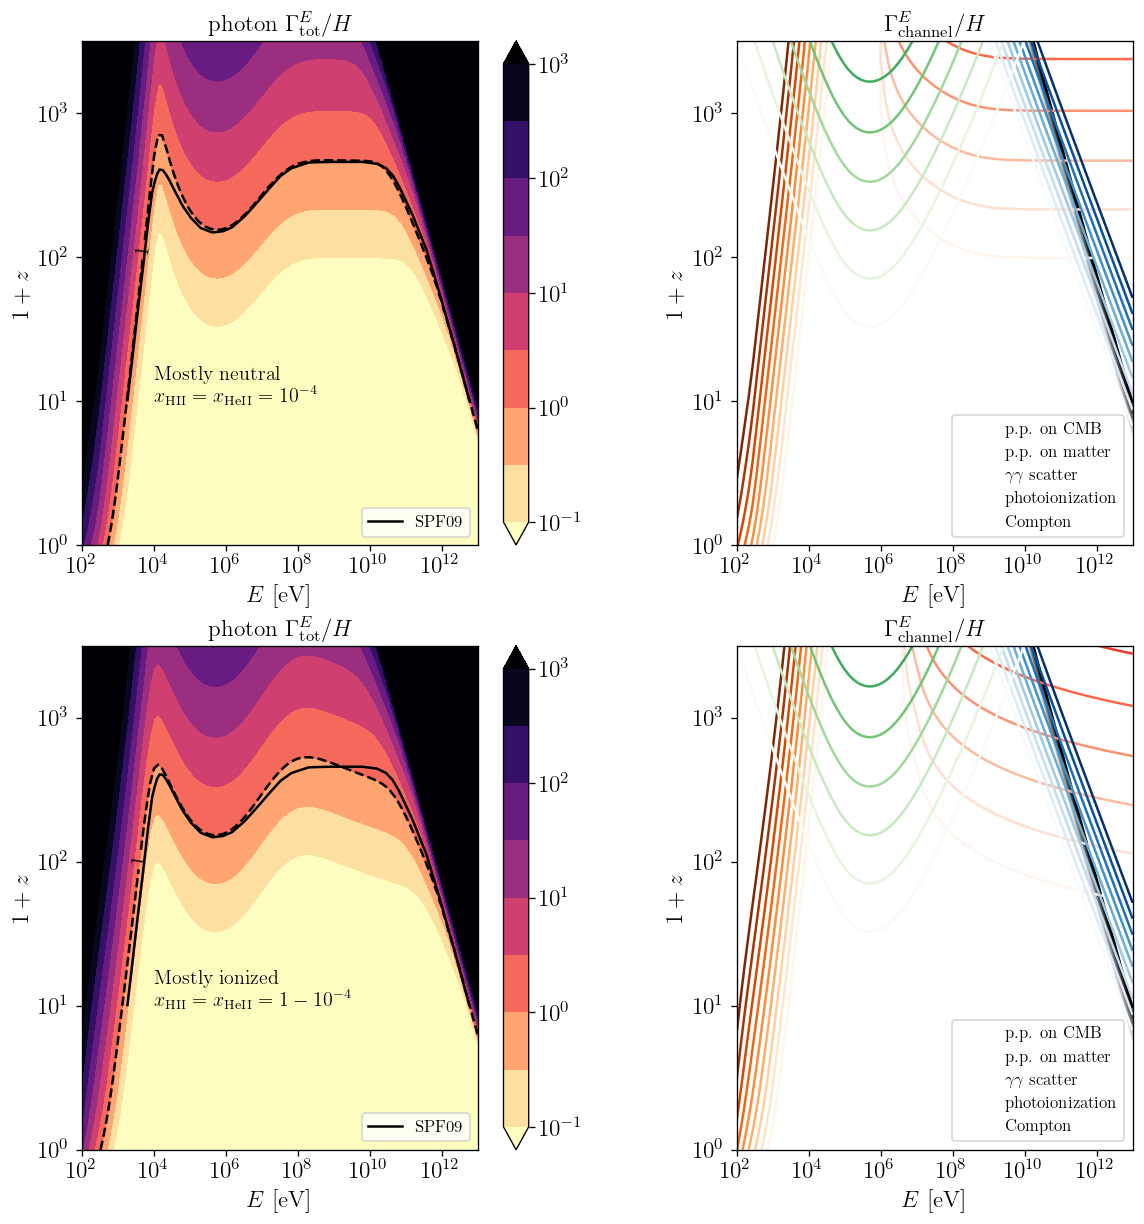

In [6]:
# plot rates
plot_cool = True
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    
    if plot_cool:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_cool_rate]
        title_left = r'photon $\Gamma^E_\mathrm{tot}/H$'
        title_right = r'$\Gamma^E_\mathrm{channel}/H$'
    else:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_rate]
        title_left  = r'photon $\Gamma_\mathrm{tot}/H$'
        title_right = r'$\Gamma_\mathrm{channel}/H$'
    
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]
    ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)

    levels = np.linspace(-1, 3, 9)
    im = axs[ik,0].contourf(x_ss, y_ss, np.log10(ratio), cmap='magma_r', levels=levels, extend='both')
    cs = axs[ik,0].contour( x_ss, y_ss, np.log10(ratio), colors='k', linestyles='--',
                            levels=np.log10([1]), extend='both')
    axs[ik,0].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
    cbar = fig.colorbar(im, ax=axs[ik,0], spacing='proportional', ticks=range_wend(-1, 3))
    cbar.ax.set_yticklabels(tento_label(range_wend(-1, 3)))
    if plot_cool:
        x_t, y_t = np.loadtxt(f'{DATA_DIR}/SPF09/tcool_tH_1.txt', unpack=True)
        axs[ik,0].plot(x_t, y_t, 'k', label='SPF09')
        axs[ik,0].legend(loc='lower right', fontsize=10)
    axs[ik,0].set_aspect(4)
    axs[ik,0].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik,0].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik,0].set_yticks(range_wend(*rs_log10lim))
    axs[ik,0].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,0].set(title=title_left, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')

    labels = ['p.p. on CMB', 'p.p. on matter', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton']
    cmaps = ['Greys', 'Reds', 'Blues', 'Oranges', 'Greens']
    for i, rate in enumerate(rates):
        ratio = np.clip(rate, 1e-100, None) / np.array(hubble_ss)
        cs = axs[ik,1].contour(x_ss, y_ss, np.log10(ratio), cmap=cmaps[i], levels=levels, extend='both')
        if i != 20:
            cs.collections[3].set_label(labels[i])
    axs[ik,1].set_aspect(4)
    axs[ik,1].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik,1].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik,1].set_yticks(range_wend(*rs_log10lim))
    axs[ik,1].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,1].set(title=title_right, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    axs[ik,1].legend(fontsize=10, loc='lower right')
    
    axs[ik,0].text(4, 1, textstr, fontsize=12, color='k')
    
    # if plot_cool:
    #     fig.savefig('cool_rate.pdf')
    # else:
    #     fig.savefig('int_rate.pdf')

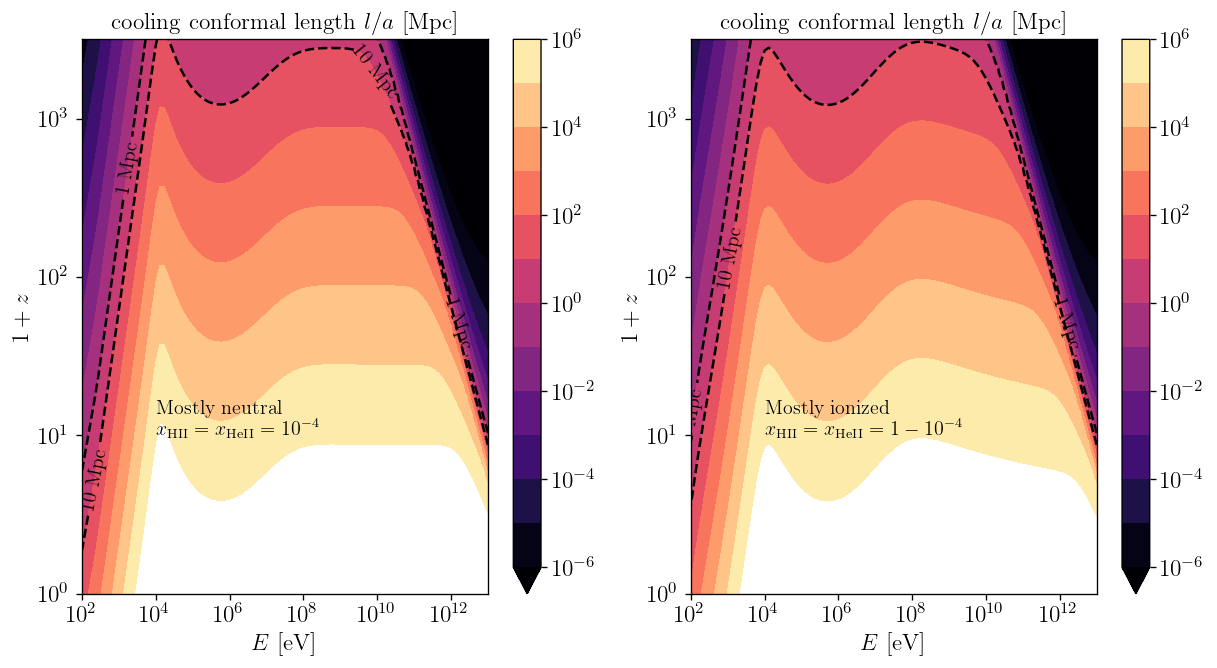

In [7]:
# plot optical depth
plot_cool = True
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    
    if plot_cool:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_cool_rate]
    else:
        funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_rate]
    title = r'cooling conformal length $l/a$ [Mpc]'
    
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]

    Mpc = 3.08568e24 # cm
    cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Ep_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Ep_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(4, 1, textstr, fontsize=12, color='k')

#     if plot_cool:
#         fig.savefig('cool_cfm_length.pdf')
#     else:
#         fig.savefig('int_cfm_length.pdf')

In [16]:
with h5py.File('../data/cooling_rates/cfdepth.h5', 'w') as f:
    f.create_dataset('cfdepth', data=cfdepth)
    f.create_dataset('rs_s', data=rs_s)
    f.create_dataset('Ep_s', data=Ep_s)

### 1.2 rates at one slice

In [40]:
Ep_s = np.geomspace(1e3, 1e12, 100)
rs = 1001
rate_ss = []
for func in [pp_CMB_rate, phph_scat_rate, photoion_rate, compton_cool_rate,
             lambda Ep, rs: pp_matter_rate(Ep, rs, 1, 0, phys.nHe/phys.nH),
             lambda Ep, rs: pp_matter_rate(Ep, rs, 0, 0, 0),
             pp_matter_fullion_ZS_rate]:
    rate_ss.append([func(Ep, rs) for Ep in Ep_s])
    print('.', end='', flush=True)
rate_ss = np.array(rate_ss)
ratio_ss = rate_ss / phys.hubble(rs)

.......

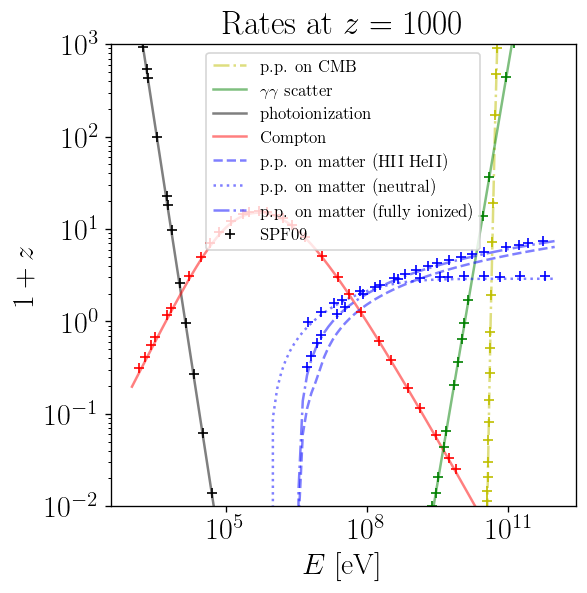

In [42]:
# plot optical depth
fig, ax = plt.subplots(figsize=(5,5))

plot_cool = True
if plot_cool:
    title = r'photon $\Gamma^E_\mathrm{tot}/H$ at $z=1000$'
else:
    title = r'photon $\Gamma_\mathrm{tot}/H$ at $z=1000$'

styles     = ['y-.', 'g-', 'k-', 'r-', 'b--', 'b:', 'b-.']
styles_spf = ['y+',  'g+', 'k+', 'r+', 'b+',  'b+', 'b+' ]
spf_fns = ['pp_CMB', 'phph_scat', 'photoion', 'compton', 'pp_matter_HII_HeII', 'pp_matter_neutral']
labels = ['p.p. on CMB', r'$\gamma\gamma$ scatter', 'photoionization', 'Compton',
          'p.p. on matter (HII HeII)', 'p.p. on matter (neutral)', 'p.p. on matter (fully ionized)']

labels_spf = ['', '', 'SPF09', '', '', '', '']

for i in range(7):
    ax.plot(Ep_s, ratio_ss[i], styles[i], label=labels[i], alpha=0.5)
for i in range(6):
    x, y = np.loadtxt('rates/SPF09/'+spf_fns[i]+'.txt', unpack=True)
    ax.plot(10**x, 10**y, styles_spf[i], label=labels_spf[i])
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e-2,1e3))
ax.legend(fontsize=10)

ax.set(title=r'Rates at $z=1000$', xlabel=r'$E$ [eV]', ylabel=r'$1+z$');
# fig.savefig('z1000rates.pdf')

### 1.3 Cooling distance for 10 keV and 1 TeV photons

In [ ]:
phys.hubble?

In [ ]:
# define grid
Ep_s = np.array([1e4, 1e12]) # [eV]
rs_s = np.linspace(6, 46, 100)
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Ep_s)))
a_ss      = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

hubble_length_ss = 1/hubble_ss * c.c.to('Mpc/s').value / a_ss # [pcm]

# calculate rates
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, phph_scat_cool_rate,
         compton_rate, compton_cool_rate, photoion_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = {}
    for func in funcs:
        name = func.__name__
        print(key, name, flush=True)
        rate_ss = []
        for rs in tqdm(rs_s):
            rate_s = []
            xHeII = xHII * phys.nHe/phys.nH
            for Ep in Ep_s:
                rate_s.append(func(Ep, rs, xHII=xHII, xHeII=xHeII))
            rate_ss.append(rate_s)
        rate_ss_dict[key][name] = rate_ss.copy()

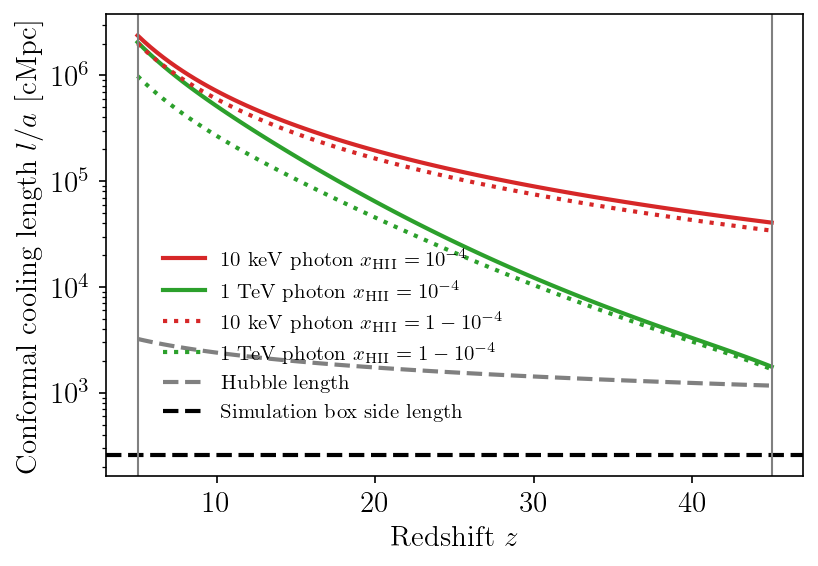

In [14]:
funcs = [pp_CMB_rate, pp_matter_rate, phph_scat_rate, photoion_rate, compton_cool_rate]

title = r'cooling conformal length $l/a$ [Mpc]'

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
ls_s = ['-', ':']
color_s = ['C0', 'C1']
xH_text_s = [r'$x_\mathrm{HII}=10^{-4}$', r'$x_\mathrm{HII}=1-10^{-4}$']
for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]

    Mpc = 3.08568e24 # cm
    cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    ax.plot(rs_s - 1, cfdepth[:, 0], ls=ls_s[ik], color='C0', label='10 keV photon '+xH_text_s[ik])
    ax.plot(rs_s - 1, cfdepth[:, 1], ls=ls_s[ik], color='C1', label='1 TeV photon '+xH_text_s[ik])

ax.plot(rs_s - 1, hubble_length_ss[:, 0], ls='--', color='gray', label='Hubble length')
ax.axhline(256, color='k', ls='--', label='Simulation box side length')
ax.axvline(5, color='gray', lw=1)
ax.axvline(45, color='gray', lw=1)
ax.set(yscale='log')
ax.set(xlabel='Redshift $z$', ylabel='Conformal cooling length $l/a$ [cMpc]')
ax.legend(fontsize=10, frameon=False, loc=(0.07, 0.1))
fig.savefig('coolinglength.pdf')

In [8]:
rate_ss_dict['xHII=1e-4'].keys()

dict_keys(['pp_CMB_rate', 'pp_matter_rate', 'phph_scat_rate', 'phph_scat_cool_rate', 'compton_rate', 'compton_cool_rate', 'photoion_rate'])

In [ ]:
Mpc = 3.08568e24 # cm
cfdepth = phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

## 1.4 Compton scattering rate for X-ray photons

In [27]:
sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys_dm21cm

In [40]:
# define grid
Ep_s = np.geomspace(1e2, 1e4, 10)
rs_s = np.geomspace(5, 45, 30)
x_ss, y_ss = np.meshgrid(np.log10(Ep_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Ep_s)))
a_ss      = np.zeros((len(rs_s), len(Ep_s)))
dt_ss     = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in enumerate(rs_s):
    for j, Ep in enumerate(Ep_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs
        dt_ss[i,j] = phys_dm21cm.dt_step(rs-1, 1.002) # [s]

In [41]:
# calculate rates
funcs = [compton_rate, compton_cool_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = {}
    for func in funcs:
        name = func.__name__
        print(key, name, flush=True)
        rate_ss = []
        for rs in tqdm(rs_s):
            rate_s = []
            xHeII = xHII * phys.nHe/phys.nH
            for Ep in Ep_s:
                rate_s.append(func(Ep, rs, xHII=xHII, xHeII=xHeII))
            rate_ss.append(rate_s)
        rate_ss_dict[key][name] = rate_ss.copy()

xHII=1e-4 compton_rate


100%|██████████| 30/30 [00:00<00:00, 6513.91it/s]

xHII=1e-4 compton_cool_rate



100%|██████████| 30/30 [00:00<00:00, 5791.37it/s]

xHII=1-1e-4 compton_rate



100%|██████████| 30/30 [00:00<00:00, 6491.06it/s]

xHII=1-1e-4 compton_cool_rate



100%|██████████| 30/30 [00:00<00:00, 5848.98it/s]


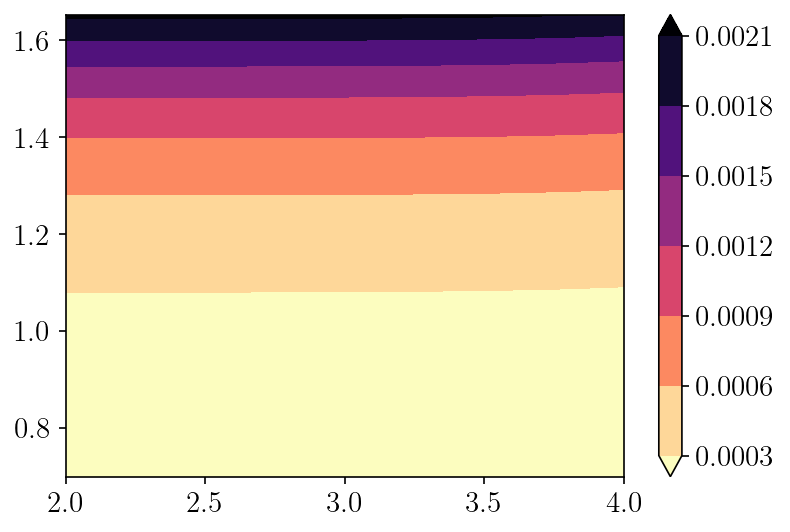

In [42]:
key = 'xHII=1e-4'
rates = [rate_ss_dict[key][name] for name in names]
ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)
interact_time = np.clip(np.sum(rates, axis=0), 1e-100, None) * dt_ss

plt.contourf(x_ss, y_ss, interact_time, cmap='magma_r', extend='both')
plt.colorbar()

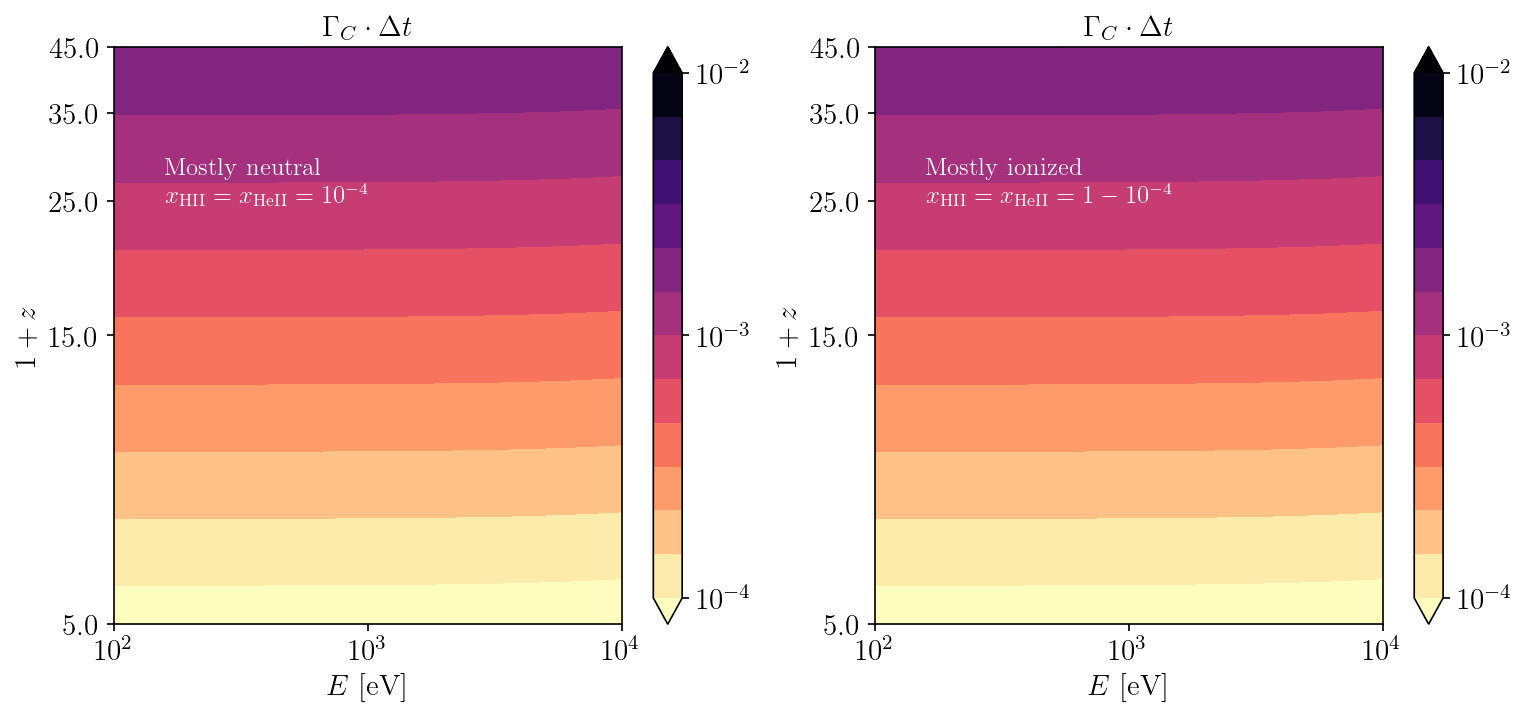

In [54]:
# plot rates
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    
    funcs = [compton_rate]
    title_left  = r'$\Gamma_C \cdot \Delta t$'
    
    names = [func.__name__ for func in funcs]
    rates = [rate_ss_dict[key][name] for name in names]
    ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)
    interact_time = np.clip(np.sum(rates, axis=0), 1e-100, None) * dt_ss

    levels = np.linspace(-4, -2, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(interact_time), cmap='magma_r', levels=levels, extend='both')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(interact_time), colors='k', linestyles='--',
                            levels=np.log10([1]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-4, -2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-4, -2)))

    # axs[ik].set_aspect(4)
    axs[ik].set_xticks(range_wend(2, 4))
    axs[ik].set_xticklabels(tento_label(range_wend(2, 4)))
    axs[ik].set_yticks(np.log10(np.linspace(5, 45, 5)))
    axs[ik].set_yticklabels(np.linspace(5, 45, 5))
    axs[ik].set(title=title_left, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(2.2, np.log10(25), textstr, fontsize=12, color='w')

## 2. electron rates

### 2.1 plot rates

In [12]:
# define grid
Eek_log10lim = (1, 9)
rs_log10lim  = (0, 2)
Eek_s = np.logspace(*Eek_log10lim, 100)
rs_s  = np.logspace(*rs_log10lim, 100)
x_ss, y_ss = np.meshgrid(np.log10(Eek_s), np.log10(rs_s))

hubble_ss = np.zeros((len(rs_s), len(Eek_s)))
a_ss      = np.zeros((len(rs_s), len(Eek_s)))
for i, rs in enumerate(rs_s):
    for j, Eek in enumerate(Eek_s):
        hubble_ss[i,j] = phys.hubble(rs)
        a_ss[i,j] = 1/rs

In [ ]:
# calculate rates
funcs = [ee_coll_rate, e_ion_rate, e_exc_rate, e_ics_rate]
rate_ss_dict = {}

for key, xHII in zip(['xHII=1e-4', 'xHII=1-1e-4'], [1e-4, 1-1e-4]):
    rate_ss_dict[key] = []
    for func in funcs:
        rate_ss = []
        for rs in rs_s:
            rate_s = []
            for Eek in Eek_s:
                rate_s.append(func(Eek, rs, xHII))
            rate_ss.append(rate_s)
        rate_ss_dict[key].append(rate_ss)

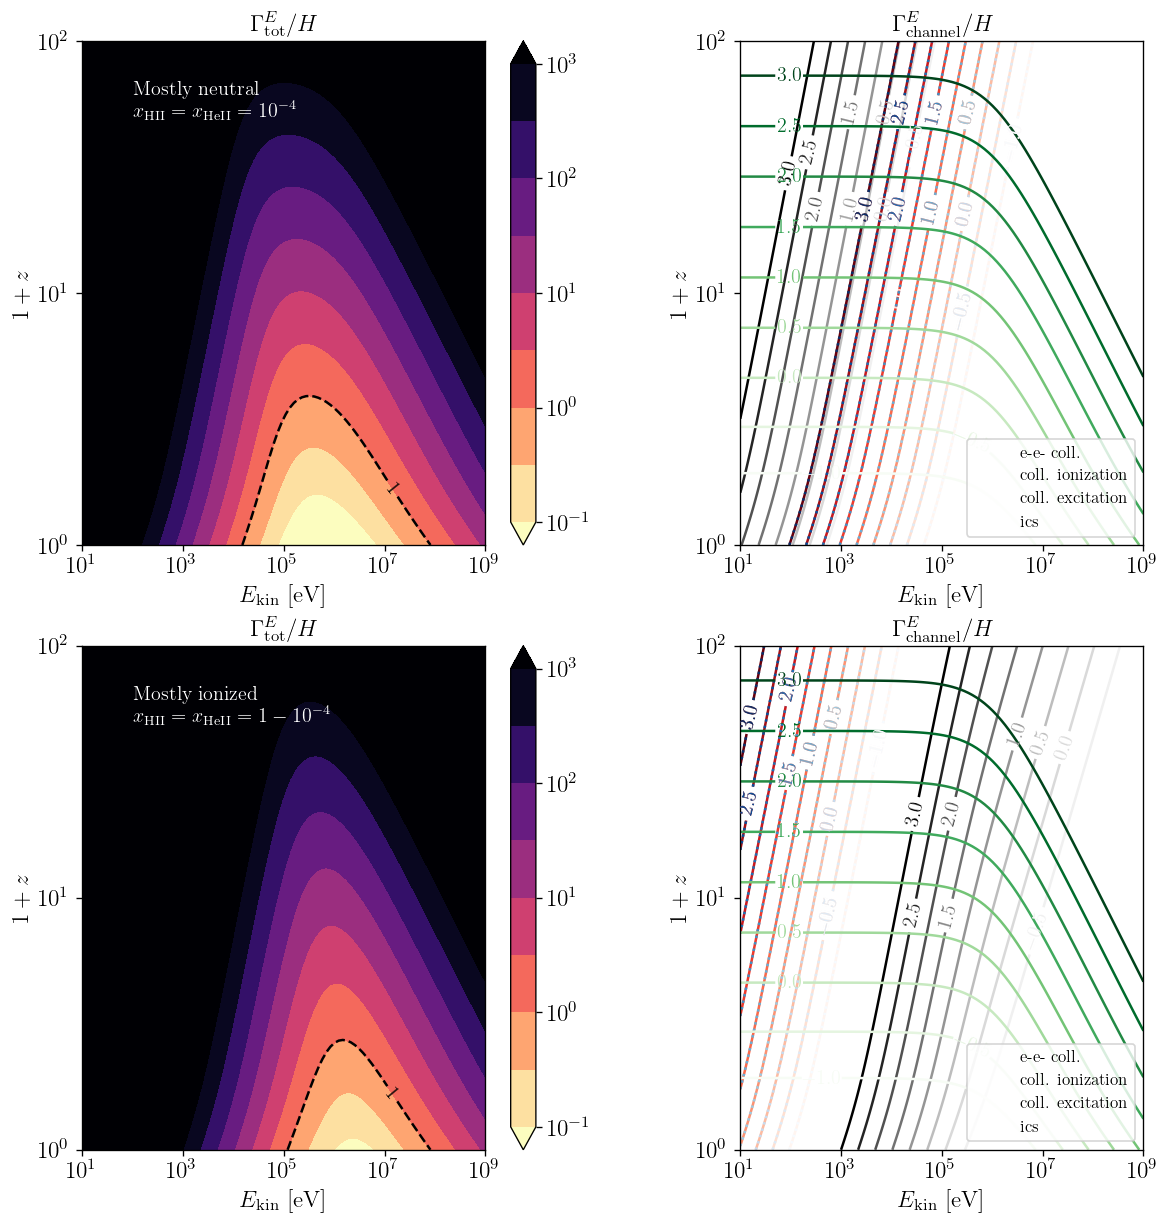

In [7]:
# plot rates
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title_left = r'$\Gamma^E_\mathrm{tot}/H~$'
    title_right = r'$\Gamma^E_\mathrm{channel}/H~$'

    rates = rate_ss_dict[key]
    ratio = np.clip(np.sum(rates, axis=0), 1e-100, None) / np.array(hubble_ss)

    levels = np.linspace(-1, 3, 9)
    im = axs[ik,0].contourf(x_ss, y_ss, np.log10(ratio), cmap='magma_r', levels=levels, extend='both')
    cs = axs[ik,0].contour( x_ss, y_ss, np.log10(ratio), colors='k', linestyles='--',
                         levels=np.log10([1]), extend='both')
    axs[ik,0].clabel(cs, cs.levels, fmt={cs.levels[0]: '1'})
    
    cbar = fig.colorbar(im, ax=axs[ik,0], spacing='proportional', ticks=range_wend(-1, 3))
    cbar.ax.set_yticklabels(tento_label(range_wend(-1, 3)))

    axs[ik,0].set_aspect(5)
    axs[ik,0].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik,0].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik,0].set_yticks(range_wend(*rs_log10lim))
    axs[ik,0].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,0].set(title=title_left, xlabel=r'$E_\mathrm{kin}$ [eV]', ylabel=r'$1+z$')

    labels = ['e-e- coll.', 'coll. ionization', 'coll. excitation', 'ics']
    cmaps = ['Greys', 'Reds', 'Blues', 'Greens']
    for i, rate in enumerate(rates):
        ratio = np.clip(rate, 1e-100, None) / np.array(hubble_ss)
        config = dict(cmap=cmaps[i], levels=levels, extend='both')
        if i == 2:
            config.update(linestyles=':')
        cs = axs[ik,1].contour(x_ss, y_ss, np.log10(ratio), **config)
        axs[ik,1].clabel(cs, cs.levels)
        if i != 20:
            cs.collections[3].set_label(labels[i])
    axs[ik,1].set_aspect(5)
    axs[ik,1].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik,1].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik,1].set_yticks(range_wend(*rs_log10lim))
    axs[ik,1].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik,1].set(title=title_right, xlabel=r'$E_\mathrm{kin}$ [eV]', ylabel=r'$1+z$')
    axs[ik,1].legend(fontsize=10, loc='lower right')
    
    axs[ik,0].text(2, 1.7, textstr, fontsize=12, color='w')

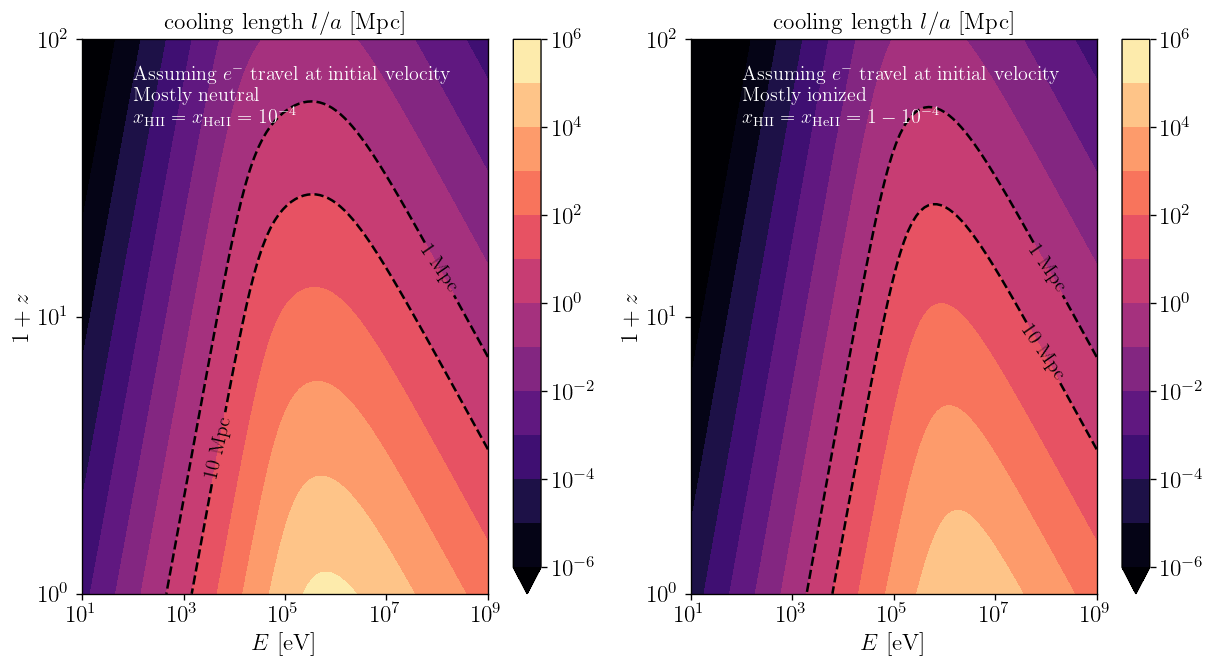

In [8]:
# plot scattering length
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title = r'cooling length $l/a$ [Mpc]'
    
    rates = rate_ss_dict[key]
    Mpc = 3.08568e24 # cm
    gamma = 1 + Eek_s / phys.me
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    cfdepth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(2, 1.7, 'Assuming $e^-$ travel at initial velocity\n'+textstr, fontsize=12, color='w')

In [14]:
# conformal dt / cooling length
sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as dc_phys
import astropy.units as u
import astropy.constants as const

cfdt_ss = np.zeros((len(rs_s), len(Eek_s)))
for i, rs in enumerate(rs_s):
    for j, Eek in enumerate(Eek_s):
        z = rs - 1
        z_next = rs / 1.01 - 1
        cfdt_ss[i,j] = (dc_phys.conformal_dt_between_z(z, z_next) * u.s * const.c).to('Mpc').value

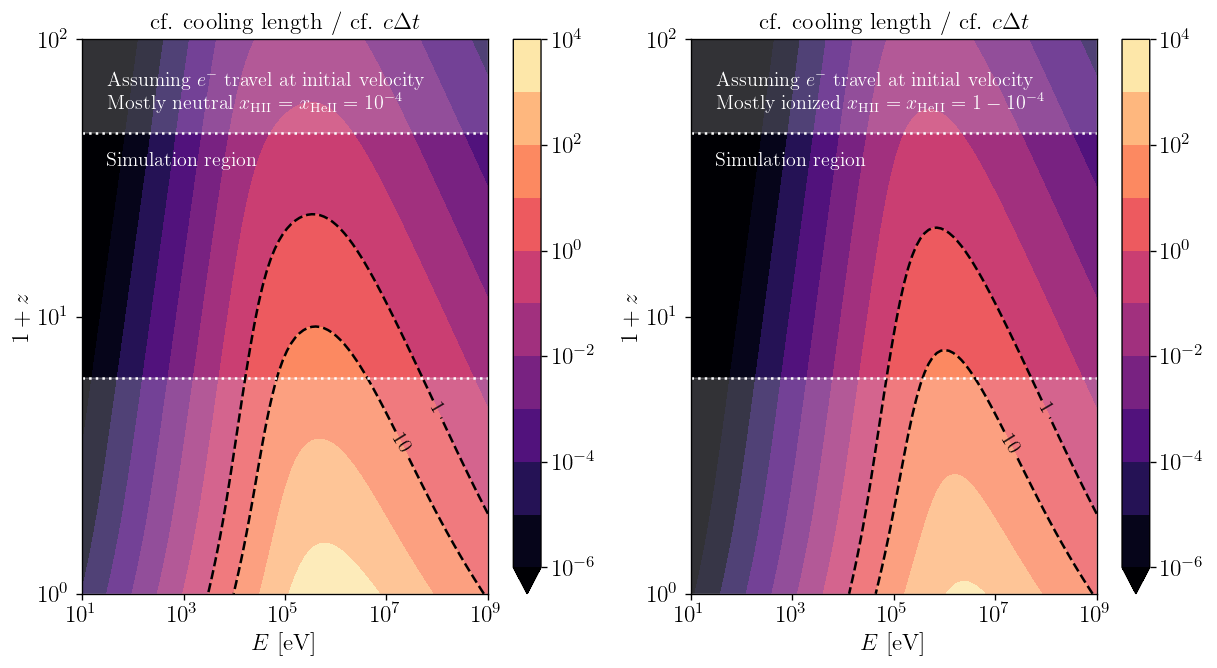

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral ' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized ' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title = r'cf. cooling length / cf. $c\Delta t$'
    
    rates = rate_ss_dict[key]
    Mpc = 3.08568e24 # cm
    gamma = 1 + Eek_s / phys.me
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    cfdepth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) / a_ss / Mpc # Mpc

    plot_ss = cfdepth / cfdt_ss

    levels = np.linspace(-6, 4, 11)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(plot_ss), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(plot_ss), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1', cs.levels[1]: '10'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 4, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 4, 2)))

    axs[ik].axhline(np.log10(45+1), color='w', ls=':')
    axs[ik].axhline(np.log10(5+1), color='w', ls=':')

    axs[ik].fill_between([1, 9], [0, 0], [np.log10(5+1), np.log10(5+1)], color='w', alpha=0.2)
    axs[ik].fill_between([1, 9], [2, 2], [np.log10(45+1), np.log10(45+1)], color='w', alpha=0.2)

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(1.5, 1.75, 'Assuming $e^-$ travel at initial velocity\n'+textstr, fontsize=12, color='w')
    axs[ik].text(1.5, np.log10(35), 'Simulation region', fontsize=12, color='w')

In [21]:
# inverse scattering length
scat_length_ss = []
for rs in rs_s:
    scat_length_s = []
    for Eek in Eek_s:
        scat_length_s.append( 1/(phys.thomson_xsec * phys.CMB_N_density(phys.TCMB(rs))) )
    scat_length_ss.append(scat_length_s)
scat_length_ss = np.array(scat_length_ss)

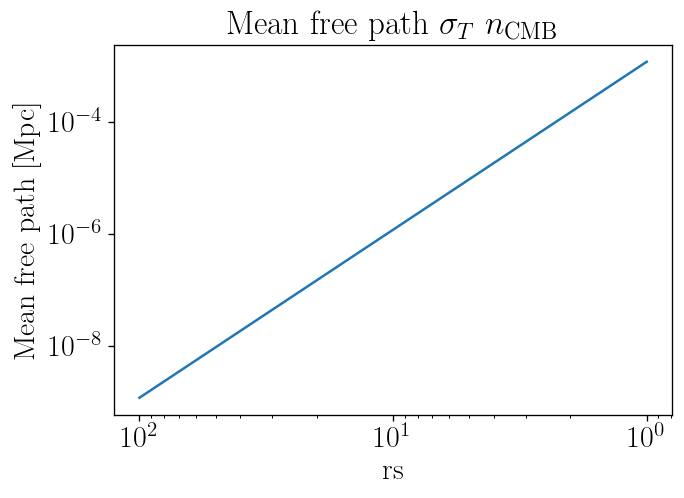

In [64]:
Mpc = 3.08568e24 # cm
inv_scat_l_s = [1/(phys.thomson_xsec * phys.CMB_N_density(phys.TCMB(rs)))/Mpc for rs in rs_s]

fig, ax = plt.subplots()
ax.plot(rs_s, inv_scat_l_s)
ax.invert_xaxis()
ax.set(xscale='log', yscale='log')
ax.set(xlabel='rs', ylabel='Mean free path [Mpc]', title=r'Mean free path $\sigma_T~n_\mathrm{CMB}$');

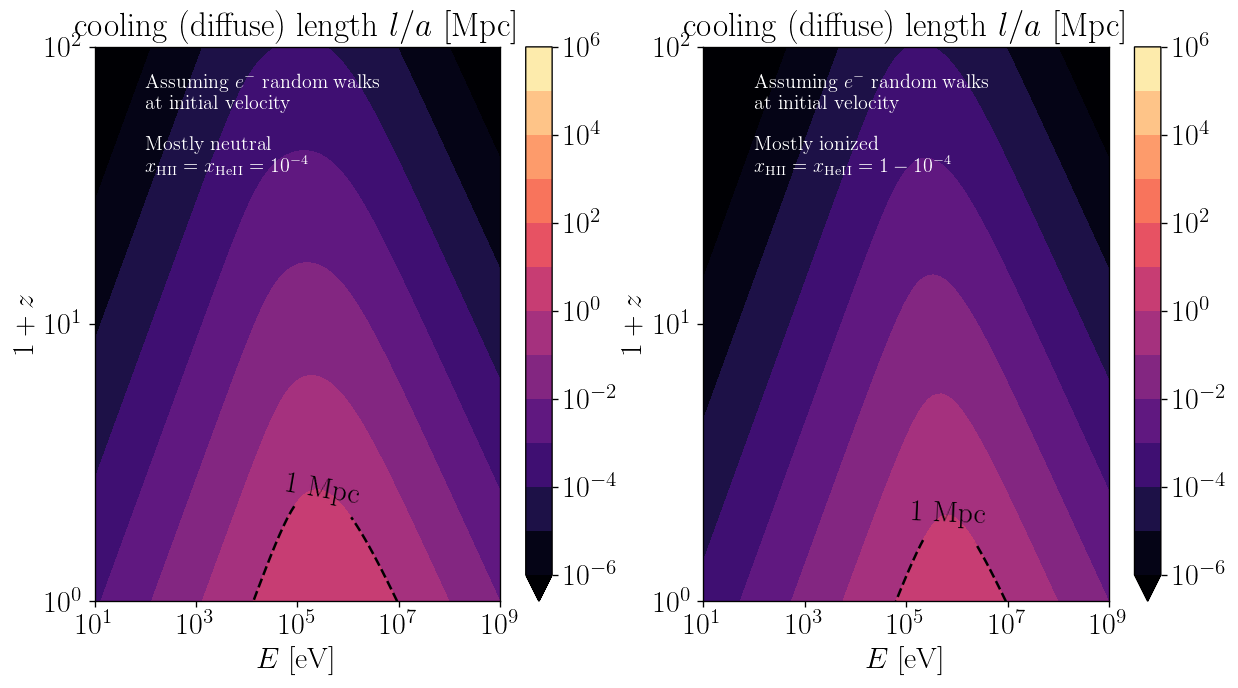

In [58]:
# plot scattering length
fig, axs = plt.subplots(1, 2, figsize=(12,6))

for ik, key in enumerate(['xHII=1e-4', 'xHII=1-1e-4']):
    names = [func.__name__ for func in funcs]
    if ik == 0:
        textstr = 'Mostly neutral\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=10^{-4}$'
    else:
        textstr = 'Mostly ionized\n' + r'$x_\mathrm{HII}=x_\mathrm{HeII}=1-10^{-4}$'
    title = r'cooling (diffuse) length $l/a$ [Mpc]'
    
    rates = rate_ss_dict[key]
    Mpc = 3.08568e24 # cm
    gamma = 1 + Eek_s / phys.me
    beta = np.sqrt(1 - 1/gamma**2)
    beta = beta[None, :]
    depth = beta * phys.c / np.clip(np.sum(rates, axis=0), 1e-100, None) # cm
    n_scat = depth / scat_length_ss
    depth = np.sqrt(n_scat) * scat_length_ss
    cfdepth = depth / a_ss / Mpc # Mpc

    levels = np.linspace(-6, 6, 13)
    im = axs[ik].contourf(x_ss, y_ss, np.log10(cfdepth), cmap='magma', levels=levels, extend='min')
    cs = axs[ik].contour( x_ss, y_ss, np.log10(cfdepth), colors='k', linestyles='--',
                          levels=np.log10([1, 10]), extend='both')
    axs[ik].clabel(cs, cs.levels, fmt={cs.levels[0]: '1 Mpc', cs.levels[1]: '10 Mpc'})
    cbar = fig.colorbar(im, ax=axs[ik], spacing='proportional', ticks=range_wend(-6, 6, 2))
    cbar.ax.set_yticklabels(tento_label(range_wend(-6, 6, 2)))

    #axs[ik].set_aspect(5)
    axs[ik].set_xticks(range_wend(*Eek_log10lim, 2))
    axs[ik].set_xticklabels(tento_label(range_wend(*Eek_log10lim, 2)))
    axs[ik].set_yticks(range_wend(*rs_log10lim))
    axs[ik].set_yticklabels(tento_label(range_wend(*rs_log10lim)))
    axs[ik].set(title=title, xlabel=r'$E$ [eV]', ylabel=r'$1+z$')
    
    axs[ik].text(2, 1.55, 'Assuming $e^-$ random walks \nat initial velocity\n\n'+textstr,
                 fontsize=12, color='w')

## Photon Optical depth

In [6]:
def d_integrand(rs): # cm
    return phys.c / (rs*phys.hubble(rs))

print('Distance', integrate.quad(d_integrand, 1, 1.15)[0] / Mpc, 'Mpc')

Distance 599.9078004161291 Mpc


In [10]:
def od_CMB_integrand(rs, Ep):
    return pp_CMB_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_CMB_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 4696.850949364589


In [11]:
def trapz_integrate(func, a, b, args=None, n=100):
    xs = np.linspace(a, b, n)
    fs = [func(x, *args) for x in xs]
    return np.trapz(fs, xs)

In [13]:
EBL_data = np.loadtxt('EBL_EdNdE.txt')
eng_EBL  = EBL_data[:, 0]
dndE_EBL = EBL_data[:, 1] / eng_EBL

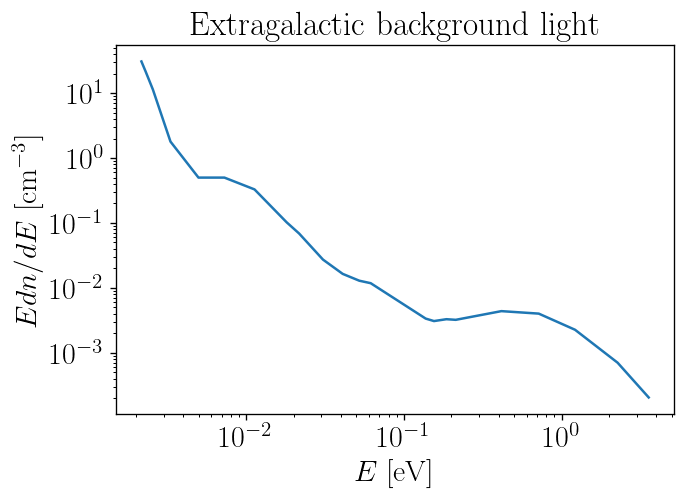

In [14]:
fig, ax = plt.subplots()
ax.plot(EBL_data[:,0], EBL_data[:,1])
ax.set(xlabel='$E$ [eV]', ylabel='$Edn/dE$ [cm$^{-3}$]', title='Extragalactic background light')
ax.set(xscale='log', yscale='log');

In [15]:
def pp_EBL_rate(Ep, rs, **kwargs): # s^-1(eV, 1)
    
    # Ep: hard, ep: soft
    emin = phys.me**2 / Ep
    i_st = np.searchsorted(eng_EBL, emin)
    #print(i_st)
    eng_binbounds = eng_EBL[i_st:] # eV
    dndE = dndE_EBL[i_st:]
    
    eng_center = (eng_binbounds[1:] + eng_binbounds[:-1]) / 2
    eng_binwidths = eng_binbounds[1:] - eng_binbounds[:-1] # eV
    dndE_center = (dndE[1:] + dndE[:-1]) / 2 # cm^-3 eV^-1
    dN_dEdt_arr = [] # eV^-1 s^-1
    
    for ep, dndE in zip(eng_center, dndE_center):
        
        E = Ep / phys.me # 1(E/me) | input hard photon energy
        e = ep / phys.me # 1(E/me) | soft photon energy
        A = E + e
        
        def integrand(Ee): # 1(1) | Ee in units of me | numerical factor in parentheses in Eq.(C1) in 0906.1197
            return ( (4*A**2*np.log(4*e*Ee*(A-Ee)/A)) / (Ee*(A-Ee))
                     - 8*e*A + (2*(2*e*A-1)*A**2) / (Ee*(A-Ee))
                     - (1-1/(e*A))*(A**4)/(Ee**2*(A-Ee)**2) )
#         intg, err = integrate.quad(integrand, A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))))
#         if np.abs(err/intg) > 1e-5:
#             raise ValueError('Large integration error.')
        xs = np.linspace(A/2*(1-np.sqrt(1-1/(E*e))), A/2*(1+np.sqrt(1-1/(E*e))), 100)
        #print(1-1/(E*e))
        intg = np.trapz(integrand(xs), xs)
        # dN/dEdt | eV^-1 s^-1 = cm^2 * cm/s * 1 * cm^-3 eV^-1
        dN_dEdt = phys.thomson_xsec * phys.c * (3/64) * (1/(e**2 * E**3)) * intg * dndE
        dN_dEdt_arr.append(dN_dEdt)
        
    rate = np.dot(dN_dEdt_arr, eng_binwidths) # s^-1
    return rate

In [17]:
def od_EBL_integrand(rs, Ep):
    return pp_EBL_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_EBL_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 759.1350746739472


In [18]:
def od_scat_CMB_integrand(rs, Ep):
    return phph_scat_rate(Ep * rs, rs) / (rs*phys.hubble(rs))

print('Optical depth', integrate.quad(od_scat_CMB_integrand, 1, 1.15, args=(250e12,))[0])

Optical depth 0.045058420941899706


In [25]:
Eps = np.logspace(np.log10(1e10), np.log10(1e15), 100)

ods_dict = {
    'pp_EBL': [],
    'pp_CMB': [],
    'scat_EBL': [],
    'scat_CMB': []
}

for Ep in tqdm(Eps):
    ods_dict['pp_EBL'].append(trapz_integrate(od_EBL_integrand, 1, 1.15, args=(Ep,)))
    ods_dict['pp_CMB'].append(trapz_integrate(od_CMB_integrand, 1, 1.15, args=(Ep,)))
    ods_dict['scat_CMB'].append(trapz_integrate(od_scat_CMB_integrand, 1, 1.15, args=(Ep,)))
    #ods_dict['scat_EBL'].append(trapz_integrate(od_scat_EBL_integrand, 1, 1.15, args=(Ep,)))

  0%|          | 0/100 [00:00<?, ?it/s]

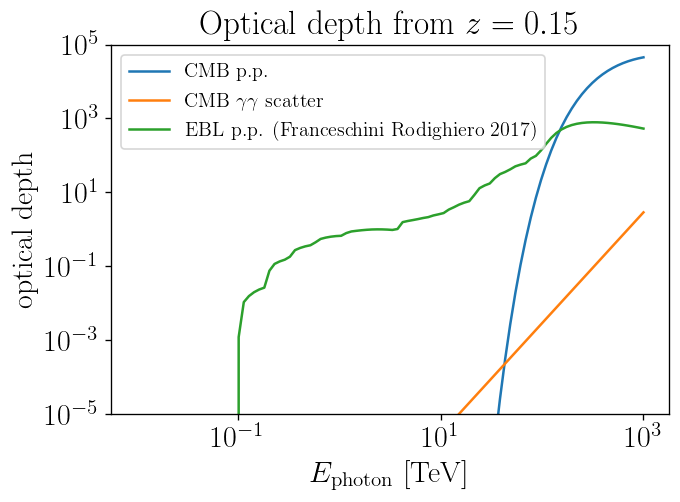

In [28]:
fig, ax = plt.subplots()
ax.plot(Eps/1e12, ods_dict['pp_CMB'], label='CMB p.p.')
ax.plot(Eps/1e12, ods_dict['scat_CMB'], label='CMB $\gamma\gamma$ scatter')
ax.plot(Eps/1e12, ods_dict['pp_EBL'], label='EBL p.p. (Franceschini Rodighiero 2017)')
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$E_\mathrm{photon}$ [TeV]', ylabel='optical depth', title='Optical depth from $z=0.15$')
ax.set(ylim=(1e-5, 1e5))
ax.legend(fontsize=12);

## Archive

In [ ]:
# darkhistory rate
hep_tf = pickle.load(open(os.environ['DH_DATA_DIR']+'/highengphot_tf_interp.raw', 'rb'))
dh_rate_ss = np.zeros((len(rs_s), len(Ep_s)))
for i, rs in tqdm(enumerate(rs_s)):
    xH  = phys.xHII_std(rs)
    xHe = phys.xHeII_std(rs)
    tf = hep_tf.get_tf(xH, xHe, rs)
    for j, Ep in enumerate(Ep_s):
        
        i = np.searchsorted(hep_tf.eng, Ep)
        dl = Ep - hep_tf.eng[i]
        dh = hep_tf.eng[i+1] - Ep
        spec_data = np.zeros(len(hep_tf.eng))
        spec_data[i]   = dh/(dl+dh)
        spec_data[i+1] = dl/(dl+dh)
        in_spec = Spectrum(hep_tf.eng, spec_data, spec_type='N')
        in_E = in_spec.toteng()
        out_spec = tf.sum_spec()
        dh_rate_ss[i,j] = 0